<div align="center">

## 17. Segmentation map으로 도로 이미지 만들기
</div>

이전 Pix2Pix 논문에서 제시한 결과중 아래와 같이 도로의 레이블 정보를 활용해 이미지를 생성한 실험이 있었다.

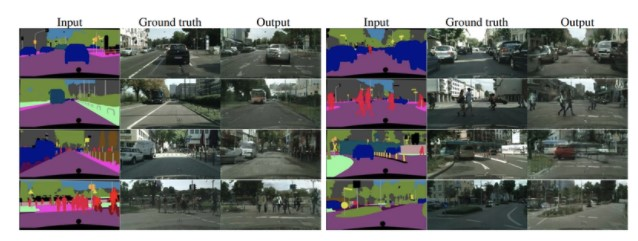

이번 프로젝트는 논문에서 사용됐던 데이터셋을 이용해 Pix2Pix를 학습시키는 것이다.

- 사용 데이터: [cityscapes.zip] 1000개의 학습용 이미지 및 5개의 평가 이미지를 포함.
- 참고 자료: [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

In [44]:
## 프로젝트 수행 전 주요 라이브러리 버전 확인
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


**프로젝트 수행**<br>

---

: 프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같다.

- 데이터에 한 가지 이상의 **augmentation 방법을 적용**하여 학습.
- 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator**를 사용.
- 모델 학습 후, 학습된 Generator를 이용해 테스트한다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용.
- 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**
- 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**남기기

---

**1. 라이브러리 불러오기**

In [45]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data

from tensorflow.keras import layers, Input, Model, losses, optimizers

**2. 데이터 로드**

In [46]:
data_path = os.getenv('HOME') + '/aiffel/exploration/miniproject/Ex17/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


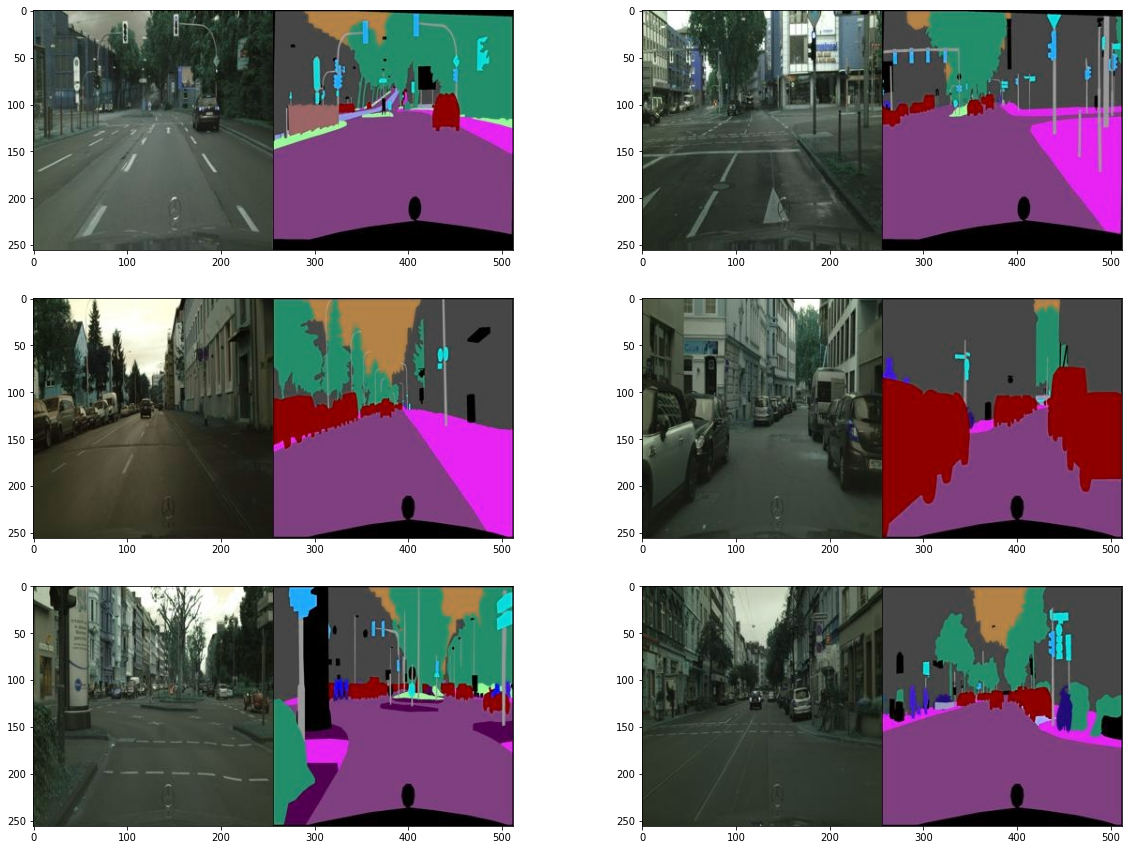

In [47]:
plt.figure(figsize=(20,15))
for i in range(1, 6+1):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [48]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


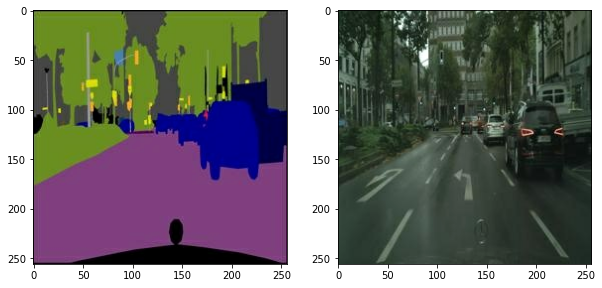

In [75]:
# 이미지 normaliz

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

**3. data augmentation**

In [50]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

: 트레인 데이터에 **apply_augmentation** 적용 후 잘 됐는지 확인(시각화)

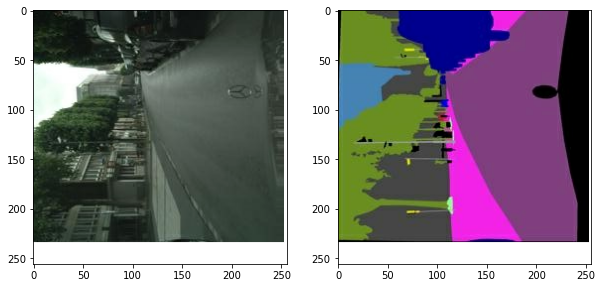

In [51]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

**4. 모델 학습을 위한 Generator 구성하기**

: Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용.

In [52]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [53]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [54]:
UNetGenerator().get_summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_64 (EncodeBlock)   (None, 128, 128, 64) 3072        input_10[0][0]                   
__________________________________________________________________________________________________
encode_block_65 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_64[0][0]            
__________________________________________________________________________________________________
encode_block_66 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_65[0][0]            
____________________________________________________________________________________________

**5. 모델 학습을 위한 Discriminator 구현하기**

In [55]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [56]:
## 간단하게 코드를 작성하여 출력의 크기가 맞는지 확인
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_154 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [57]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [58]:
Discriminator().get_summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 256, 256, 6)  0           input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
disc_block_30 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_20[0][0]      

: 확인 차 임의의 (256,256,3) 크기의 입력을 넣어 (30,30) 출력이 나오는지 시각화

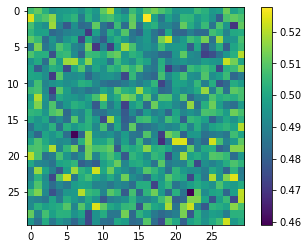

In [59]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

**6. 학습을 위한 손실 함수 및 옵티마이저 정의**

In [60]:
# 손실함수 설정

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.
- Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

In [61]:
# 옵티마이저 설정

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

**7. 모델 구성**

In [62]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

**8. 모델 학습**

In [63]:
EPOCHS = 350

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.1019                     
L1_loss:0.2370                     
Discriminator_loss:0.8821

EPOCH[1] - STEP[100]                     
Generator_loss:1.6379                     
L1_loss:0.2677                     
Discriminator_loss:0.4555

EPOCH[1] - STEP[150]                     
Generator_loss:2.6214                     
L1_loss:0.2114                     
Discriminator_loss:1.3344

EPOCH[1] - STEP[200]                     
Generator_loss:1.0483                     
L1_loss:0.2518                     
Discriminator_loss:0.7597

EPOCH[1] - STEP[250]                     
Generator_loss:2.2629                     
L1_loss:0.2398                     
Discriminator_loss:0.2840

EPOCH[2] - STEP[50]                     
Generator_loss:2.6352                     
L1_loss:0.2272                     
Discriminator_loss:0.7107

EPOCH[2] - STEP[100]                     
Generator_loss:2.8888                     
L1_loss:0.2324               

EPOCH[12] - STEP[100]                     
Generator_loss:1.1437                     
L1_loss:0.1527                     
Discriminator_loss:0.8021

EPOCH[12] - STEP[150]                     
Generator_loss:1.9242                     
L1_loss:0.2185                     
Discriminator_loss:0.2787

EPOCH[12] - STEP[200]                     
Generator_loss:2.8174                     
L1_loss:0.1646                     
Discriminator_loss:0.4006

EPOCH[12] - STEP[250]                     
Generator_loss:1.1175                     
L1_loss:0.2031                     
Discriminator_loss:0.5499

EPOCH[13] - STEP[50]                     
Generator_loss:1.5678                     
L1_loss:0.1801                     
Discriminator_loss:0.6831

EPOCH[13] - STEP[100]                     
Generator_loss:2.5170                     
L1_loss:0.1838                     
Discriminator_loss:0.3387

EPOCH[13] - STEP[150]                     
Generator_loss:2.8552                     
L1_loss:0.1461       

EPOCH[23] - STEP[150]                     
Generator_loss:0.6530                     
L1_loss:0.1411                     
Discriminator_loss:0.9729

EPOCH[23] - STEP[200]                     
Generator_loss:1.7766                     
L1_loss:0.1355                     
Discriminator_loss:1.0331

EPOCH[23] - STEP[250]                     
Generator_loss:1.3812                     
L1_loss:0.1708                     
Discriminator_loss:1.7784

EPOCH[24] - STEP[50]                     
Generator_loss:2.7964                     
L1_loss:0.1478                     
Discriminator_loss:0.2182

EPOCH[24] - STEP[100]                     
Generator_loss:1.4637                     
L1_loss:0.1872                     
Discriminator_loss:0.4107

EPOCH[24] - STEP[150]                     
Generator_loss:2.2190                     
L1_loss:0.1488                     
Discriminator_loss:0.6813

EPOCH[24] - STEP[200]                     
Generator_loss:0.9125                     
L1_loss:0.1400       

EPOCH[34] - STEP[200]                     
Generator_loss:2.3192                     
L1_loss:0.1389                     
Discriminator_loss:0.9844

EPOCH[34] - STEP[250]                     
Generator_loss:1.7774                     
L1_loss:0.1417                     
Discriminator_loss:0.4647

EPOCH[35] - STEP[50]                     
Generator_loss:2.2988                     
L1_loss:0.1321                     
Discriminator_loss:0.2551

EPOCH[35] - STEP[100]                     
Generator_loss:2.1910                     
L1_loss:0.1249                     
Discriminator_loss:0.2698

EPOCH[35] - STEP[150]                     
Generator_loss:2.4395                     
L1_loss:0.1564                     
Discriminator_loss:0.3673

EPOCH[35] - STEP[200]                     
Generator_loss:1.8830                     
L1_loss:0.1305                     
Discriminator_loss:0.3742

EPOCH[35] - STEP[250]                     
Generator_loss:2.5966                     
L1_loss:0.1394       

EPOCH[45] - STEP[250]                     
Generator_loss:1.5302                     
L1_loss:0.1439                     
Discriminator_loss:0.4345

EPOCH[46] - STEP[50]                     
Generator_loss:2.0476                     
L1_loss:0.1693                     
Discriminator_loss:0.2374

EPOCH[46] - STEP[100]                     
Generator_loss:1.2654                     
L1_loss:0.1780                     
Discriminator_loss:0.5857

EPOCH[46] - STEP[150]                     
Generator_loss:1.6976                     
L1_loss:0.1751                     
Discriminator_loss:0.4618

EPOCH[46] - STEP[200]                     
Generator_loss:2.2435                     
L1_loss:0.1419                     
Discriminator_loss:0.4122

EPOCH[46] - STEP[250]                     
Generator_loss:1.3231                     
L1_loss:0.1504                     
Discriminator_loss:0.6785

EPOCH[47] - STEP[50]                     
Generator_loss:0.9284                     
L1_loss:0.1290        

EPOCH[57] - STEP[50]                     
Generator_loss:4.4310                     
L1_loss:0.1609                     
Discriminator_loss:1.4742

EPOCH[57] - STEP[100]                     
Generator_loss:4.3574                     
L1_loss:0.1717                     
Discriminator_loss:0.3419

EPOCH[57] - STEP[150]                     
Generator_loss:1.1871                     
L1_loss:0.1599                     
Discriminator_loss:0.5530

EPOCH[57] - STEP[200]                     
Generator_loss:3.7898                     
L1_loss:0.1442                     
Discriminator_loss:0.1412

EPOCH[57] - STEP[250]                     
Generator_loss:2.5230                     
L1_loss:0.1381                     
Discriminator_loss:0.2619

EPOCH[58] - STEP[50]                     
Generator_loss:2.8776                     
L1_loss:0.1123                     
Discriminator_loss:0.5762

EPOCH[58] - STEP[100]                     
Generator_loss:4.1295                     
L1_loss:0.2040        

EPOCH[68] - STEP[100]                     
Generator_loss:2.2583                     
L1_loss:0.1555                     
Discriminator_loss:0.4178

EPOCH[68] - STEP[150]                     
Generator_loss:2.7253                     
L1_loss:0.1650                     
Discriminator_loss:0.1650

EPOCH[68] - STEP[200]                     
Generator_loss:3.8271                     
L1_loss:0.1166                     
Discriminator_loss:0.6889

EPOCH[68] - STEP[250]                     
Generator_loss:2.1400                     
L1_loss:0.0989                     
Discriminator_loss:0.4956

EPOCH[69] - STEP[50]                     
Generator_loss:3.7433                     
L1_loss:0.1446                     
Discriminator_loss:0.1093

EPOCH[69] - STEP[100]                     
Generator_loss:3.2712                     
L1_loss:0.1345                     
Discriminator_loss:0.1833

EPOCH[69] - STEP[150]                     
Generator_loss:1.6292                     
L1_loss:0.1297       

EPOCH[79] - STEP[150]                     
Generator_loss:2.1636                     
L1_loss:0.1474                     
Discriminator_loss:0.2281

EPOCH[79] - STEP[200]                     
Generator_loss:4.7031                     
L1_loss:0.1424                     
Discriminator_loss:0.1912

EPOCH[79] - STEP[250]                     
Generator_loss:3.8344                     
L1_loss:0.1502                     
Discriminator_loss:0.1316

EPOCH[80] - STEP[50]                     
Generator_loss:2.9182                     
L1_loss:0.1614                     
Discriminator_loss:0.2263

EPOCH[80] - STEP[100]                     
Generator_loss:2.1316                     
L1_loss:0.1559                     
Discriminator_loss:0.4342

EPOCH[80] - STEP[150]                     
Generator_loss:1.8814                     
L1_loss:0.1337                     
Discriminator_loss:0.5741

EPOCH[80] - STEP[200]                     
Generator_loss:4.0203                     
L1_loss:0.1320       

EPOCH[90] - STEP[200]                     
Generator_loss:2.6418                     
L1_loss:0.0969                     
Discriminator_loss:0.8889

EPOCH[90] - STEP[250]                     
Generator_loss:4.7799                     
L1_loss:0.1681                     
Discriminator_loss:0.0408

EPOCH[91] - STEP[50]                     
Generator_loss:4.7852                     
L1_loss:0.1245                     
Discriminator_loss:0.4192

EPOCH[91] - STEP[100]                     
Generator_loss:2.8065                     
L1_loss:0.1394                     
Discriminator_loss:0.1736

EPOCH[91] - STEP[150]                     
Generator_loss:3.7164                     
L1_loss:0.1218                     
Discriminator_loss:0.1674

EPOCH[91] - STEP[200]                     
Generator_loss:2.0371                     
L1_loss:0.1386                     
Discriminator_loss:0.3192

EPOCH[91] - STEP[250]                     
Generator_loss:2.5895                     
L1_loss:0.1350       

EPOCH[101] - STEP[250]                     
Generator_loss:5.4054                     
L1_loss:0.1033                     
Discriminator_loss:0.0884

EPOCH[102] - STEP[50]                     
Generator_loss:2.8629                     
L1_loss:0.1179                     
Discriminator_loss:0.1388

EPOCH[102] - STEP[100]                     
Generator_loss:4.9912                     
L1_loss:0.1237                     
Discriminator_loss:0.3796

EPOCH[102] - STEP[150]                     
Generator_loss:1.5754                     
L1_loss:0.1185                     
Discriminator_loss:0.3676

EPOCH[102] - STEP[200]                     
Generator_loss:8.0250                     
L1_loss:0.1133                     
Discriminator_loss:0.3068

EPOCH[102] - STEP[250]                     
Generator_loss:3.3098                     
L1_loss:0.1240                     
Discriminator_loss:0.0899

EPOCH[103] - STEP[50]                     
Generator_loss:6.4827                     
L1_loss:0.1862 

EPOCH[112] - STEP[250]                     
Generator_loss:3.0030                     
L1_loss:0.1476                     
Discriminator_loss:0.1221

EPOCH[113] - STEP[50]                     
Generator_loss:7.0954                     
L1_loss:0.1220                     
Discriminator_loss:0.8175

EPOCH[113] - STEP[100]                     
Generator_loss:1.3519                     
L1_loss:0.1141                     
Discriminator_loss:0.5850

EPOCH[113] - STEP[150]                     
Generator_loss:5.0630                     
L1_loss:0.1220                     
Discriminator_loss:0.0457

EPOCH[113] - STEP[200]                     
Generator_loss:2.1256                     
L1_loss:0.1133                     
Discriminator_loss:0.2085

EPOCH[113] - STEP[250]                     
Generator_loss:6.1398                     
L1_loss:0.1400                     
Discriminator_loss:0.2405

EPOCH[114] - STEP[50]                     
Generator_loss:5.0276                     
L1_loss:0.1378 

EPOCH[123] - STEP[250]                     
Generator_loss:5.6059                     
L1_loss:0.1478                     
Discriminator_loss:0.3820

EPOCH[124] - STEP[50]                     
Generator_loss:3.0270                     
L1_loss:0.1705                     
Discriminator_loss:0.1156

EPOCH[124] - STEP[100]                     
Generator_loss:1.3007                     
L1_loss:0.1333                     
Discriminator_loss:0.8252

EPOCH[124] - STEP[150]                     
Generator_loss:1.4300                     
L1_loss:0.1088                     
Discriminator_loss:0.5956

EPOCH[124] - STEP[200]                     
Generator_loss:5.3543                     
L1_loss:0.1055                     
Discriminator_loss:0.1729

EPOCH[124] - STEP[250]                     
Generator_loss:4.7523                     
L1_loss:0.1244                     
Discriminator_loss:0.2148

EPOCH[125] - STEP[50]                     
Generator_loss:4.9373                     
L1_loss:0.1335 

EPOCH[134] - STEP[250]                     
Generator_loss:6.6708                     
L1_loss:0.1398                     
Discriminator_loss:0.4123

EPOCH[135] - STEP[50]                     
Generator_loss:2.4831                     
L1_loss:0.1175                     
Discriminator_loss:0.2729

EPOCH[135] - STEP[100]                     
Generator_loss:4.0389                     
L1_loss:0.1574                     
Discriminator_loss:0.2923

EPOCH[135] - STEP[150]                     
Generator_loss:3.0013                     
L1_loss:0.1105                     
Discriminator_loss:0.1389

EPOCH[135] - STEP[200]                     
Generator_loss:3.5585                     
L1_loss:0.1111                     
Discriminator_loss:0.2468

EPOCH[135] - STEP[250]                     
Generator_loss:5.7519                     
L1_loss:0.1474                     
Discriminator_loss:0.0103

EPOCH[136] - STEP[50]                     
Generator_loss:0.8782                     
L1_loss:0.1107 

EPOCH[145] - STEP[250]                     
Generator_loss:1.0725                     
L1_loss:0.0921                     
Discriminator_loss:0.6801

EPOCH[146] - STEP[50]                     
Generator_loss:3.7836                     
L1_loss:0.1608                     
Discriminator_loss:0.0876

EPOCH[146] - STEP[100]                     
Generator_loss:2.8770                     
L1_loss:0.1046                     
Discriminator_loss:0.1853

EPOCH[146] - STEP[150]                     
Generator_loss:6.2981                     
L1_loss:0.1089                     
Discriminator_loss:0.2039

EPOCH[146] - STEP[200]                     
Generator_loss:4.1051                     
L1_loss:0.1445                     
Discriminator_loss:0.1022

EPOCH[146] - STEP[250]                     
Generator_loss:4.4634                     
L1_loss:0.1134                     
Discriminator_loss:0.1529

EPOCH[147] - STEP[50]                     
Generator_loss:5.9990                     
L1_loss:0.1170 

EPOCH[156] - STEP[250]                     
Generator_loss:2.4096                     
L1_loss:0.1272                     
Discriminator_loss:0.3784

EPOCH[157] - STEP[50]                     
Generator_loss:1.7777                     
L1_loss:0.1120                     
Discriminator_loss:0.5032

EPOCH[157] - STEP[100]                     
Generator_loss:3.3453                     
L1_loss:0.1064                     
Discriminator_loss:0.1298

EPOCH[157] - STEP[150]                     
Generator_loss:2.5825                     
L1_loss:0.1117                     
Discriminator_loss:0.1523

EPOCH[157] - STEP[200]                     
Generator_loss:4.6343                     
L1_loss:0.1396                     
Discriminator_loss:0.1339

EPOCH[157] - STEP[250]                     
Generator_loss:0.2437                     
L1_loss:0.1329                     
Discriminator_loss:2.6990

EPOCH[158] - STEP[50]                     
Generator_loss:5.8908                     
L1_loss:0.1172 

EPOCH[167] - STEP[250]                     
Generator_loss:7.5477                     
L1_loss:0.1218                     
Discriminator_loss:0.6254

EPOCH[168] - STEP[50]                     
Generator_loss:0.6983                     
L1_loss:0.1171                     
Discriminator_loss:1.3154

EPOCH[168] - STEP[100]                     
Generator_loss:4.9580                     
L1_loss:0.1244                     
Discriminator_loss:0.0616

EPOCH[168] - STEP[150]                     
Generator_loss:4.5010                     
L1_loss:0.1047                     
Discriminator_loss:0.1893

EPOCH[168] - STEP[200]                     
Generator_loss:2.6048                     
L1_loss:0.1154                     
Discriminator_loss:0.2573

EPOCH[168] - STEP[250]                     
Generator_loss:6.2841                     
L1_loss:0.1296                     
Discriminator_loss:0.0142

EPOCH[169] - STEP[50]                     
Generator_loss:3.5763                     
L1_loss:0.1122 

EPOCH[178] - STEP[250]                     
Generator_loss:6.4790                     
L1_loss:0.1502                     
Discriminator_loss:0.0172

EPOCH[179] - STEP[50]                     
Generator_loss:4.2359                     
L1_loss:0.1645                     
Discriminator_loss:0.0447

EPOCH[179] - STEP[100]                     
Generator_loss:6.1549                     
L1_loss:0.1397                     
Discriminator_loss:0.0086

EPOCH[179] - STEP[150]                     
Generator_loss:3.6014                     
L1_loss:0.1063                     
Discriminator_loss:0.0894

EPOCH[179] - STEP[200]                     
Generator_loss:5.3047                     
L1_loss:0.1438                     
Discriminator_loss:0.0130

EPOCH[179] - STEP[250]                     
Generator_loss:3.7364                     
L1_loss:0.1257                     
Discriminator_loss:0.2877

EPOCH[180] - STEP[50]                     
Generator_loss:6.9851                     
L1_loss:0.1067 

EPOCH[189] - STEP[250]                     
Generator_loss:2.7844                     
L1_loss:0.1159                     
Discriminator_loss:0.2160

EPOCH[190] - STEP[50]                     
Generator_loss:5.0980                     
L1_loss:0.1101                     
Discriminator_loss:0.2510

EPOCH[190] - STEP[100]                     
Generator_loss:4.6854                     
L1_loss:0.1079                     
Discriminator_loss:0.1659

EPOCH[190] - STEP[150]                     
Generator_loss:4.3986                     
L1_loss:0.1049                     
Discriminator_loss:0.1088

EPOCH[190] - STEP[200]                     
Generator_loss:3.2126                     
L1_loss:0.1136                     
Discriminator_loss:0.1011

EPOCH[190] - STEP[250]                     
Generator_loss:4.0292                     
L1_loss:0.1344                     
Discriminator_loss:0.0664

EPOCH[191] - STEP[50]                     
Generator_loss:4.0721                     
L1_loss:0.1243 

EPOCH[200] - STEP[250]                     
Generator_loss:3.1497                     
L1_loss:0.1100                     
Discriminator_loss:0.4487

EPOCH[201] - STEP[50]                     
Generator_loss:6.6714                     
L1_loss:0.1136                     
Discriminator_loss:0.0245

EPOCH[201] - STEP[100]                     
Generator_loss:2.6978                     
L1_loss:0.1142                     
Discriminator_loss:0.2966

EPOCH[201] - STEP[150]                     
Generator_loss:1.3712                     
L1_loss:0.1244                     
Discriminator_loss:0.6434

EPOCH[201] - STEP[200]                     
Generator_loss:11.2441                     
L1_loss:0.1158                     
Discriminator_loss:5.6287

EPOCH[201] - STEP[250]                     
Generator_loss:5.1230                     
L1_loss:0.1122                     
Discriminator_loss:0.0410

EPOCH[202] - STEP[50]                     
Generator_loss:4.4264                     
L1_loss:0.1813

EPOCH[211] - STEP[250]                     
Generator_loss:1.4136                     
L1_loss:0.1397                     
Discriminator_loss:1.4696

EPOCH[212] - STEP[50]                     
Generator_loss:2.9758                     
L1_loss:0.1481                     
Discriminator_loss:0.1418

EPOCH[212] - STEP[100]                     
Generator_loss:3.6912                     
L1_loss:0.1006                     
Discriminator_loss:0.0758

EPOCH[212] - STEP[150]                     
Generator_loss:5.0706                     
L1_loss:0.0953                     
Discriminator_loss:0.0464

EPOCH[212] - STEP[200]                     
Generator_loss:0.1709                     
L1_loss:0.1097                     
Discriminator_loss:2.4529

EPOCH[212] - STEP[250]                     
Generator_loss:2.9501                     
L1_loss:0.1149                     
Discriminator_loss:0.1165

EPOCH[213] - STEP[50]                     
Generator_loss:2.5393                     
L1_loss:0.1288 

EPOCH[222] - STEP[250]                     
Generator_loss:5.5699                     
L1_loss:0.1301                     
Discriminator_loss:0.6399

EPOCH[223] - STEP[50]                     
Generator_loss:4.9481                     
L1_loss:0.0900                     
Discriminator_loss:0.1464

EPOCH[223] - STEP[100]                     
Generator_loss:2.9594                     
L1_loss:0.1208                     
Discriminator_loss:0.4950

EPOCH[223] - STEP[150]                     
Generator_loss:6.7512                     
L1_loss:0.1234                     
Discriminator_loss:0.0612

EPOCH[223] - STEP[200]                     
Generator_loss:4.9628                     
L1_loss:0.1364                     
Discriminator_loss:0.0858

EPOCH[223] - STEP[250]                     
Generator_loss:6.6050                     
L1_loss:0.1303                     
Discriminator_loss:0.0772

EPOCH[224] - STEP[50]                     
Generator_loss:5.1922                     
L1_loss:0.1094 

EPOCH[233] - STEP[250]                     
Generator_loss:5.2071                     
L1_loss:0.1427                     
Discriminator_loss:0.0782

EPOCH[234] - STEP[50]                     
Generator_loss:5.4800                     
L1_loss:0.1395                     
Discriminator_loss:0.0130

EPOCH[234] - STEP[100]                     
Generator_loss:0.7856                     
L1_loss:0.1017                     
Discriminator_loss:1.3087

EPOCH[234] - STEP[150]                     
Generator_loss:6.3987                     
L1_loss:0.1046                     
Discriminator_loss:0.0993

EPOCH[234] - STEP[200]                     
Generator_loss:1.4865                     
L1_loss:0.1103                     
Discriminator_loss:1.1121

EPOCH[234] - STEP[250]                     
Generator_loss:3.1592                     
L1_loss:0.1060                     
Discriminator_loss:0.1560

EPOCH[235] - STEP[50]                     
Generator_loss:8.2459                     
L1_loss:0.1313 

EPOCH[244] - STEP[250]                     
Generator_loss:6.1611                     
L1_loss:0.1201                     
Discriminator_loss:0.0090

EPOCH[245] - STEP[50]                     
Generator_loss:4.2330                     
L1_loss:0.1331                     
Discriminator_loss:0.0411

EPOCH[245] - STEP[100]                     
Generator_loss:5.9310                     
L1_loss:0.0955                     
Discriminator_loss:0.7001

EPOCH[245] - STEP[150]                     
Generator_loss:6.5281                     
L1_loss:0.1166                     
Discriminator_loss:0.0498

EPOCH[245] - STEP[200]                     
Generator_loss:4.8001                     
L1_loss:0.1341                     
Discriminator_loss:0.0520

EPOCH[245] - STEP[250]                     
Generator_loss:4.1037                     
L1_loss:0.1421                     
Discriminator_loss:0.0486

EPOCH[246] - STEP[50]                     
Generator_loss:3.8761                     
L1_loss:0.1137 

EPOCH[255] - STEP[250]                     
Generator_loss:5.6535                     
L1_loss:0.1329                     
Discriminator_loss:0.0562

EPOCH[256] - STEP[50]                     
Generator_loss:0.8496                     
L1_loss:0.1559                     
Discriminator_loss:1.1106

EPOCH[256] - STEP[100]                     
Generator_loss:5.0631                     
L1_loss:0.1202                     
Discriminator_loss:0.0270

EPOCH[256] - STEP[150]                     
Generator_loss:2.9924                     
L1_loss:0.1344                     
Discriminator_loss:0.1611

EPOCH[256] - STEP[200]                     
Generator_loss:6.5814                     
L1_loss:0.1170                     
Discriminator_loss:0.0039

EPOCH[256] - STEP[250]                     
Generator_loss:0.3464                     
L1_loss:0.1122                     
Discriminator_loss:2.0520

EPOCH[257] - STEP[50]                     
Generator_loss:3.0012                     
L1_loss:0.1359 

EPOCH[266] - STEP[250]                     
Generator_loss:5.8636                     
L1_loss:0.1115                     
Discriminator_loss:0.7545

EPOCH[267] - STEP[50]                     
Generator_loss:5.1789                     
L1_loss:0.1511                     
Discriminator_loss:0.0187

EPOCH[267] - STEP[100]                     
Generator_loss:7.4056                     
L1_loss:0.1642                     
Discriminator_loss:0.0017

EPOCH[267] - STEP[150]                     
Generator_loss:4.5367                     
L1_loss:0.1294                     
Discriminator_loss:0.0283

EPOCH[267] - STEP[200]                     
Generator_loss:5.5923                     
L1_loss:0.1320                     
Discriminator_loss:0.1696

EPOCH[267] - STEP[250]                     
Generator_loss:4.5732                     
L1_loss:0.1202                     
Discriminator_loss:0.0274

EPOCH[268] - STEP[50]                     
Generator_loss:3.9266                     
L1_loss:0.1009 

EPOCH[277] - STEP[250]                     
Generator_loss:7.7983                     
L1_loss:0.1150                     
Discriminator_loss:1.9374

EPOCH[278] - STEP[50]                     
Generator_loss:4.7355                     
L1_loss:0.1136                     
Discriminator_loss:0.0576

EPOCH[278] - STEP[100]                     
Generator_loss:3.4318                     
L1_loss:0.1280                     
Discriminator_loss:0.1305

EPOCH[278] - STEP[150]                     
Generator_loss:5.6388                     
L1_loss:0.1624                     
Discriminator_loss:0.0097

EPOCH[278] - STEP[200]                     
Generator_loss:4.8150                     
L1_loss:0.1036                     
Discriminator_loss:0.1879

EPOCH[278] - STEP[250]                     
Generator_loss:6.5446                     
L1_loss:0.1773                     
Discriminator_loss:0.0066

EPOCH[279] - STEP[50]                     
Generator_loss:4.7929                     
L1_loss:0.1081 

EPOCH[288] - STEP[250]                     
Generator_loss:2.5074                     
L1_loss:0.1377                     
Discriminator_loss:0.3248

EPOCH[289] - STEP[50]                     
Generator_loss:3.2303                     
L1_loss:0.1853                     
Discriminator_loss:0.1152

EPOCH[289] - STEP[100]                     
Generator_loss:3.5488                     
L1_loss:0.1253                     
Discriminator_loss:0.4763

EPOCH[289] - STEP[150]                     
Generator_loss:7.1726                     
L1_loss:0.1602                     
Discriminator_loss:0.0030

EPOCH[289] - STEP[200]                     
Generator_loss:2.5418                     
L1_loss:0.1089                     
Discriminator_loss:0.4225

EPOCH[289] - STEP[250]                     
Generator_loss:3.2712                     
L1_loss:0.1234                     
Discriminator_loss:0.0819

EPOCH[290] - STEP[50]                     
Generator_loss:4.1611                     
L1_loss:0.1074 

EPOCH[299] - STEP[250]                     
Generator_loss:4.1605                     
L1_loss:0.1227                     
Discriminator_loss:0.0362

EPOCH[300] - STEP[50]                     
Generator_loss:1.7722                     
L1_loss:0.0898                     
Discriminator_loss:0.7073

EPOCH[300] - STEP[100]                     
Generator_loss:7.2116                     
L1_loss:0.1356                     
Discriminator_loss:0.3020

EPOCH[300] - STEP[150]                     
Generator_loss:3.3703                     
L1_loss:0.1103                     
Discriminator_loss:0.1203

EPOCH[300] - STEP[200]                     
Generator_loss:7.6373                     
L1_loss:0.1760                     
Discriminator_loss:0.0196

EPOCH[300] - STEP[250]                     
Generator_loss:3.9309                     
L1_loss:0.1242                     
Discriminator_loss:0.0899

EPOCH[301] - STEP[50]                     
Generator_loss:2.1926                     
L1_loss:0.1428 

EPOCH[310] - STEP[250]                     
Generator_loss:3.7509                     
L1_loss:0.0992                     
Discriminator_loss:0.0931

EPOCH[311] - STEP[50]                     
Generator_loss:2.3411                     
L1_loss:0.1182                     
Discriminator_loss:0.4154

EPOCH[311] - STEP[100]                     
Generator_loss:2.6942                     
L1_loss:0.1108                     
Discriminator_loss:0.2029

EPOCH[311] - STEP[150]                     
Generator_loss:3.9690                     
L1_loss:0.1036                     
Discriminator_loss:0.3254

EPOCH[311] - STEP[200]                     
Generator_loss:5.1877                     
L1_loss:0.1314                     
Discriminator_loss:0.0145

EPOCH[311] - STEP[250]                     
Generator_loss:5.3210                     
L1_loss:0.1282                     
Discriminator_loss:0.0115

EPOCH[312] - STEP[50]                     
Generator_loss:5.9245                     
L1_loss:0.1535 

EPOCH[321] - STEP[250]                     
Generator_loss:5.3427                     
L1_loss:0.1102                     
Discriminator_loss:0.0169

EPOCH[322] - STEP[50]                     
Generator_loss:2.6204                     
L1_loss:0.1159                     
Discriminator_loss:0.3418

EPOCH[322] - STEP[100]                     
Generator_loss:4.9351                     
L1_loss:0.0953                     
Discriminator_loss:0.0264

EPOCH[322] - STEP[150]                     
Generator_loss:4.9199                     
L1_loss:0.1182                     
Discriminator_loss:0.1623

EPOCH[322] - STEP[200]                     
Generator_loss:1.8286                     
L1_loss:0.1071                     
Discriminator_loss:0.4022

EPOCH[322] - STEP[250]                     
Generator_loss:3.9770                     
L1_loss:0.1586                     
Discriminator_loss:0.0853

EPOCH[323] - STEP[50]                     
Generator_loss:4.6178                     
L1_loss:0.1103 

EPOCH[332] - STEP[250]                     
Generator_loss:3.7400                     
L1_loss:0.1018                     
Discriminator_loss:0.3811

EPOCH[333] - STEP[50]                     
Generator_loss:0.5909                     
L1_loss:0.1238                     
Discriminator_loss:1.5282

EPOCH[333] - STEP[100]                     
Generator_loss:1.9682                     
L1_loss:0.1437                     
Discriminator_loss:0.6026

EPOCH[333] - STEP[150]                     
Generator_loss:2.6017                     
L1_loss:0.1081                     
Discriminator_loss:0.2075

EPOCH[333] - STEP[200]                     
Generator_loss:4.5321                     
L1_loss:0.1543                     
Discriminator_loss:0.0467

EPOCH[333] - STEP[250]                     
Generator_loss:3.7196                     
L1_loss:0.1425                     
Discriminator_loss:0.0537

EPOCH[334] - STEP[50]                     
Generator_loss:4.0673                     
L1_loss:0.1104 

EPOCH[343] - STEP[250]                     
Generator_loss:5.0277                     
L1_loss:0.1057                     
Discriminator_loss:0.0237

EPOCH[344] - STEP[50]                     
Generator_loss:3.0781                     
L1_loss:0.1109                     
Discriminator_loss:0.1287

EPOCH[344] - STEP[100]                     
Generator_loss:3.1804                     
L1_loss:0.0991                     
Discriminator_loss:0.0773

EPOCH[344] - STEP[150]                     
Generator_loss:1.8220                     
L1_loss:0.1184                     
Discriminator_loss:0.3551

EPOCH[344] - STEP[200]                     
Generator_loss:3.5436                     
L1_loss:0.1228                     
Discriminator_loss:0.0534

EPOCH[344] - STEP[250]                     
Generator_loss:2.0223                     
L1_loss:0.1124                     
Discriminator_loss:0.3005

EPOCH[345] - STEP[50]                     
Generator_loss:3.7931                     
L1_loss:0.1162 

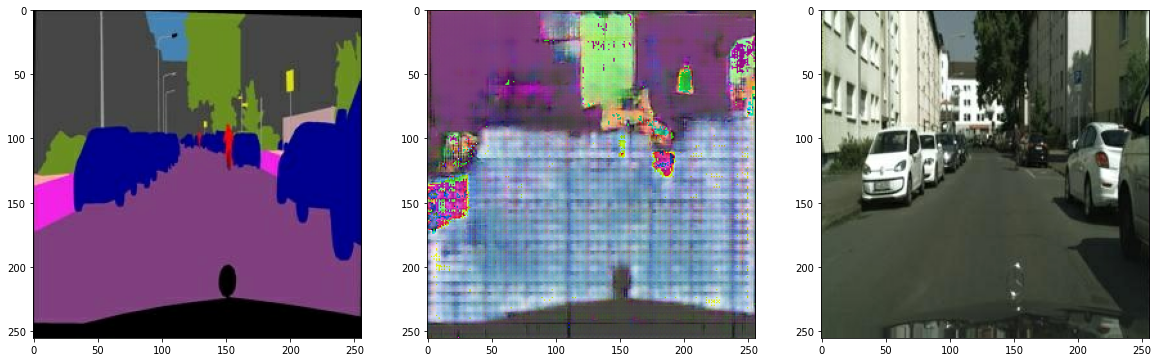

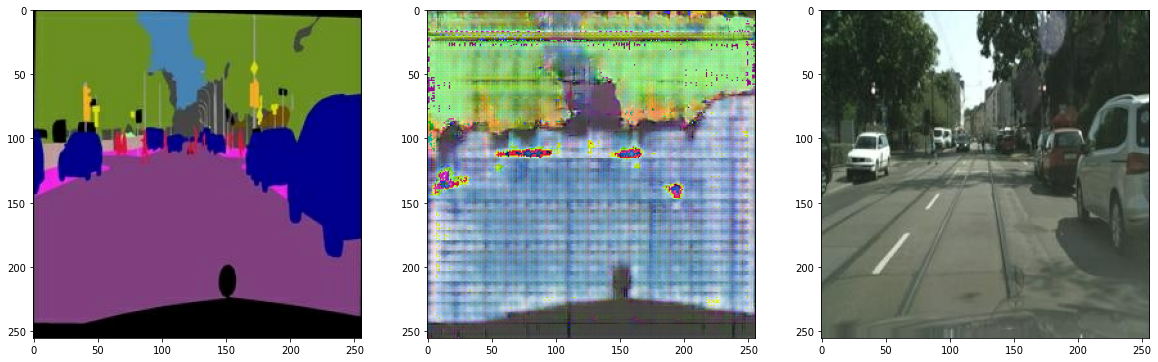

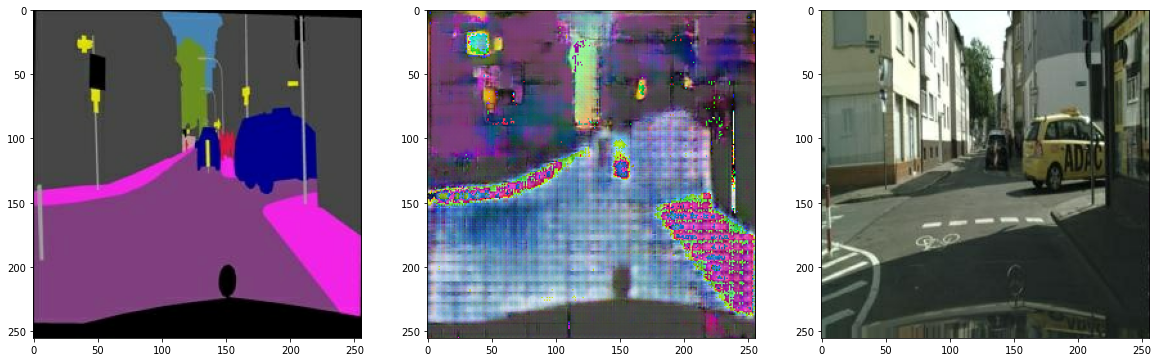

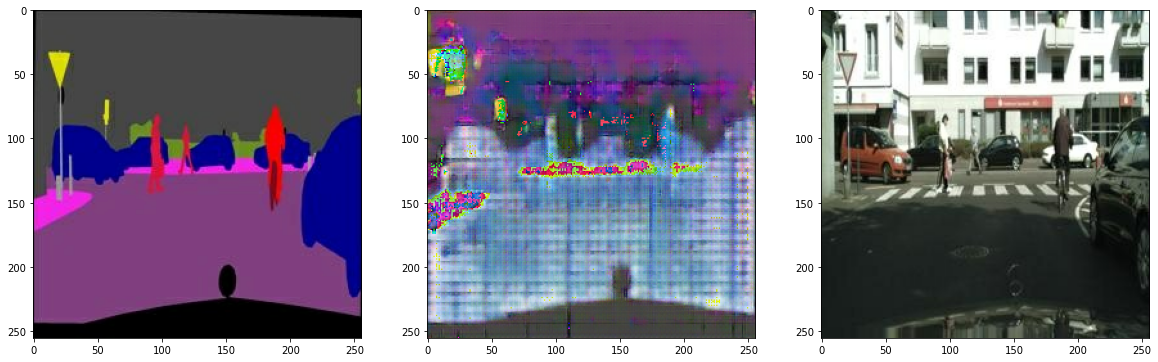

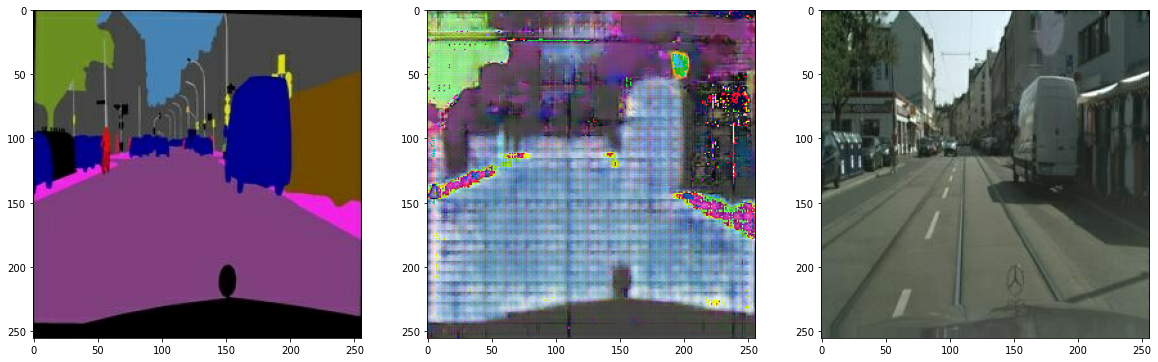

In [80]:
test_path = os.getenv("HOME") + '/aiffel/exploration/miniproject/Ex17/cityscapes/val/'

for i in range(4+1):
    test_ind = i

    f = test_path + os.listdir(test_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))